In [1]:
# Importing Required Libraries

import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Initialize the training and validation generators

train_dir = 'data/train'
test_dir = 'data/test'
train_datagenerator = ImageDataGenerator(rescale=1./255)
test_datagenerator = ImageDataGenerator(rescale=1./255)

train_generator = train_datagenerator.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

test_generator = test_datagenerator.flow_from_directory(
        test_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [3]:
# Building the CNN architecture
# with four conv2D layers, two dense layers and one flatten layer

recognition_model = Sequential()

recognition_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
recognition_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
recognition_model.add(MaxPooling2D(pool_size=(2, 2)))
recognition_model.add(Dropout(0.25))

recognition_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
recognition_model.add(MaxPooling2D(pool_size=(2, 2)))
recognition_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
recognition_model.add(MaxPooling2D(pool_size=(2, 2)))
recognition_model.add(Dropout(0.25))

recognition_model.add(Flatten())
recognition_model.add(Dense(1024, activation='relu'))
recognition_model.add(Dropout(0.5))
recognition_model.add(Dense(7, activation='softmax'))

In [4]:
# Getting Model Summary

recognition_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                    

In [5]:
# Disable OpenCL

cv2.ocl.setUseOpenCL(False)

In [6]:
# Compile Model

recognition_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=1e-6),metrics=['accuracy'])

In [7]:
# Train the model

recognition_model_info = recognition_model.fit(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=10,
        validation_data=test_generator,
        validation_steps=7178 // 64)

Epoch 1/10
448/448 [==============================] - 953s 2s/step - loss: 1.8009 - accuracy: 0.2595 - val_loss: 1.7001 - val_accuracy: 0.3288
Epoch 2/10
448/448 [==============================] - 233s 520ms/step - loss: 1.6165 - accuracy: 0.3696 - val_loss: 1.5269 - val_accuracy: 0.4220
Epoch 3/10
448/448 [==============================] - 250s 559ms/step - loss: 1.5155 - accuracy: 0.4151 - val_loss: 1.4676 - val_accuracy: 0.4315
Epoch 4/10
448/448 [==============================] - 243s 542ms/step - loss: 1.4476 - accuracy: 0.4428 - val_loss: 1.3933 - val_accuracy: 0.4657
Epoch 5/10
448/448 [==============================] - 256s 571ms/step - loss: 1.3892 - accuracy: 0.4701 - val_loss: 1.3378 - val_accuracy: 0.4912
Epoch 6/10
448/448 [==============================] - 275s 614ms/step - loss: 1.3359 - accuracy: 0.4904 - val_loss: 1.3006 - val_accuracy: 0.5092
Epoch 7/10
448/448 [==============================] - 264s 589ms/step - loss: 1.2884 - accuracy: 0.5117 - val_loss: 1.2637 - va

In [8]:
# Saving the trained Model Weights

recognition_model.save_weights('recognition_model.h5')

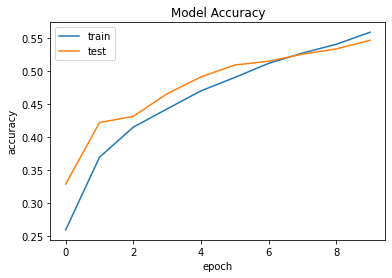

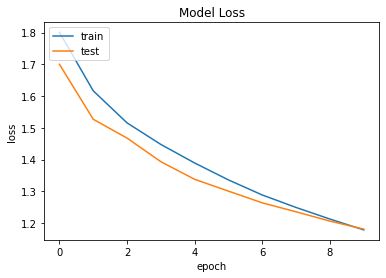

In [9]:
# Summarize history for accuracy

plt.title('Model Accuracy')
plt.plot(recognition_model_info.history['accuracy'])
plt.plot(recognition_model_info.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss

plt.title('Model Loss')
plt.plot(recognition_model_info.history['loss'])
plt.plot(recognition_model_info.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
# Facial emotion Dictonary with values

facial_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

In [ ]:
# Start the webcam feed

cap = cv2.VideoCapture(0)
while True:
    # Find haar cascade to draw bounding box around face
    ret, frame = cap.read()
    if not ret:
        break
    bounding_box = cv2.CascadeClassifier('haarcascades_cuda/haarcascade_frontalface_default.xml')
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    num_faces = bounding_box.detectMultiScale(gray_frame,scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in num_faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
        roi_gray_frame = gray_frame[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)
        facial_prediction = recognition_model.predict(cropped_img)
        maxindex = int(np.argmax(facial_prediction))
        cv2.putText(frame, facial_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('Video', cv2.resize(frame,(1200,860),interpolation = cv2.INTER_CUBIC))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 34ms/step
